# Image Captioning — BUTD (full pipeline)

Notebook chuẩn: đọc dữ liệu SCAN COCO precomp, build vocab từ COCO, dựng dataloader, định nghĩa model UpDown (BUTD 2-LSTM), huấn luyện XE (OneCycleLR + AdamW + label smoothing), lưu checkpoint, vẽ đồ thị, dự đoán trên validation và đánh giá COCO (Bleu/METEOR/CIDEr/SPICE).

Hãy chạy tuần tự các ô. Các đường dẫn mặc định lấy từ: `/kaggle/input/scan-features/data/data/coco_precomp` và `/kaggle/working/coco`.

Chỉnh `CFG` cell nếu cần.

In [1]:
# Install (nếu cần)
!pip install -q pycocotools pycocoevalcap

import os, sys
from pathlib import Path
import json
import re
from collections import Counter, defaultdict
import random
import time
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

print('torch', torch.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.6 MB/s eta 0:00:0000:0100:01
torch 2.6.0+cu124


In [2]:
# ---------------- CONFIG (chỉnh tại đây) ----------------
ROOT_SCAN = Path('/kaggle/input/scan-features/data/data/coco_precomp')
OUT_DIR   = Path('/kaggle/working')
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# training config
BATCH_TRAIN = 128
BATCH_IMG = 128
BATCH_SCST = 48
WORKERS = 4
PIN_MEMORY = False
EPOCHS = 10    # change for real run (e.g. 10+)
FT_LR = 1e-4
WEIGHT_DECAY = 1e-5
ONECYCLE_MAX_LR = 3e-4
FT_EPOCHS = 10
MAXLEN = 30

SCAN_DIR = ROOT_SCAN
COCO_OUT = OUT_DIR / 'coco'
COCO_OUT.mkdir(parents=True, exist_ok=True)

print('SCAN_DIR', SCAN_DIR)


SCAN_DIR /kaggle/input/scan-features/data/data/coco_precomp


In [3]:
# ---------- Helpers: read files and tokenization ----------
def read_lines(p):
        return [ln.rstrip('\n') for ln in open(p, encoding='utf-8')]
def read_caps(p):
        return [ln.strip() for ln in read_lines(p) if ln.strip()]
def read_ids(p):
        out=[]
        for ln in read_lines(p):
            t=ln.strip()
            if not t: continue
            # take first integer on the line
            try:
                out.append(int(t.split()[0]))
            except:
                out.append(int(t))
        return out
def simple_tok(s: str):
        return re.findall(r"[a-z0-9]+", s.lower())

# quick check files exist
for name in ['train_caps.txt','train_ids.txt','train_ims.npy','dev_caps.txt','dev_ids.txt','dev_ims.npy']:
        p = SCAN_DIR / name
        print(name, 'exists=', p.exists())


train_caps.txt exists= True
train_ids.txt exists= True
train_ims.npy exists= True
dev_caps.txt exists= True
dev_ids.txt exists= True
dev_ims.npy exists= True


In [4]:
# ---------- Build COCO-style JSONs (train/dev/test) from SCAN files ----------
def build_coco_json(split_name, caps, ids, out_dir):
        uniq_idx = sorted(set(ids))
        idx2imgid = {idx: i+1 for i, idx in enumerate(uniq_idx)}
        images = [{"id": idx2imgid[idx], "file_name": f"{split_name}_{idx}.jpg", "height": 0, "width": 0}
                  for idx in uniq_idx]
        anns = []
        aid = 1
        for c, idx in zip(caps, ids):
            anns.append({"id": aid, "image_id": idx2imgid[idx], "caption": c})
            aid += 1
        out = out_dir / ("captions_train2014.json" if split_name=='train' else ("captions_val2014.json" if split_name=='dev' else 'captions_test2014.json'))
        json.dump({"images": images, "annotations": anns, "type": "captions", "licenses": [], "info": {}}, open(out, 'w', encoding='utf-8'), ensure_ascii=False)
        print(f"wrote {out} | images={len(images)} anns={len(anns)})")
        return out
# build files (only if not exist to avoid overwrite)
train_caps = read_caps(SCAN_DIR / 'train_caps.txt')
train_ids  = read_ids(SCAN_DIR / 'train_ids.txt')
dev_caps = read_caps(SCAN_DIR / 'dev_caps.txt')
dev_ids  = read_ids(SCAN_DIR / 'dev_ids.txt')
test_caps = read_caps(SCAN_DIR / 'test_caps.txt')
test_ids  = read_ids(SCAN_DIR / 'test_ids.txt')

# If train_ids is image-level (29k) then repeat 5
    
if len(train_ids) * 5 == len(train_caps):
        train_cap2img = []
        for idx in train_ids:
            train_cap2img.extend([idx]*5)
    
else:
        train_cap2img = train_ids
if not (COCO_OUT / 'captions_train2014.json').exists():
        build_coco_json('train', train_caps, train_cap2img, COCO_OUT)
if not (COCO_OUT / 'captions_val2014.json').exists():
        build_coco_json('dev', dev_caps, dev_ids, COCO_OUT)
if not (COCO_OUT / 'captions_test2014.json').exists():
        build_coco_json('test', test_caps, test_ids, COCO_OUT)

VAL_JSON = COCO_OUT / 'captions_val2014.json'


wrote /kaggle/working/coco/captions_train2014.json | images=113287 anns=566435)
wrote /kaggle/working/coco/captions_val2014.json | images=1000 anns=5000)
wrote /kaggle/working/coco/captions_test2014.json | images=1000 anns=5000)


In [ ]:
# ---------- Build vocab from COCO train captions (min_freq configurable) ----------
with open(COCO_OUT / 'captions_train2014.json', 'r', encoding='utf-8') as f:
        cj = json.load(f)
caps_all = [a['caption'] for a in cj['annotations']]
cnt = Counter()
    
for c in caps_all:
        cnt.update(simple_tok(c))
MIN_FREQ = 5
itos = ['<pad>','<bos>','<eos>','<unk>'] + [w for w,f in cnt.items() if f>=MIN_FREQ]
stoi = {w:i for i,w in enumerate(itos)}
PAD, BOS, EOS, UNK = stoi['<pad>'], stoi['<bos>'], stoi['<eos>'], stoi['<unk>']
print('Vocab size:', len(itos))
# ---------- SAVE VOCAB (chuẩn app/eval) ----------
import json, os, time

# itos, stoi, PAD, BOS, EOS, UNK đã có sẵn từ cell trước
# ví dụ:
# itos = ['<pad>','<bos>','<eos>','<unk>', 'a', 'man', ...]
# stoi = {w:i for i,w in enumerate(itos)}
# PAD, BOS, EOS, UNK = 0,1,2,3

# sanity checks
assert PAD == 0 and BOS == 1 and EOS == 2 and UNK == 3, \
    f"Special token indices must be PAD=0,BOS=1,EOS=2,UNK=3 (got PAD={PAD},BOS={BOS},EOS={EOS},UNK={UNK})"
assert itos[PAD] == "<pad>" and itos[BOS] == "<bos>" and itos[EOS] == "<eos>" and itos[UNK] == "<unk>", \
    "Special tokens mismatch in itos."
assert len(itos) == len(stoi), "itos and stoi size mismatch!"
for w, i in stoi.items():
    assert itos[i] == w, f"Mismatch mapping stoi->itos at word={w}, idx={i}"

# file output
MIN_FREQ = MIN_FREQ  # dùng lại biến MIN_FREQ bạn đã đặt ở cell trước
out_path = os.path.abspath(f"vocab_coco_min{MIN_FREQ}.json")

vocab = {
    "itos": itos,              # list: idx -> token
    "stoi": stoi,              # dict: token -> idx
    "ids":  {"PAD": PAD, "BOS": BOS, "EOS": EOS, "UNK": UNK},
    "specials": {"pad": "<pad>", "bos": "<bos>", "eos": "<eos>", "unk": "<unk>"},
    "meta": {
        "dataset": "COCO train2014",
        "min_freq": int(MIN_FREQ),
        "size": len(itos),
        "ts": int(time.time())
    }
}

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(vocab, f, ensure_ascii=False)
print("Saved vocab to:", out_path, "| vocab_size =", len(itos))


Vocab size: 9974


In [19]:
# ---------- Datasets & DataLoaders ----------
class ScanTrainCapAligned(Dataset):
        def __init__(self, X_mmap, caps, cap2row, max_len=20):
            self.X = X_mmap
            self.caps = caps
            self.cap2row = cap2row
            self.max_len = max_len
        def __len__(self): return len(self.cap2row)
        def __getitem__(self, i):
            row = int(self.cap2row[i])
            x = np.asarray(self.X[row], dtype=np.float32)
            return torch.from_numpy(x), self.caps[i]

def first_row_per_image(cap2img_ids):
        first={}
        for r,iid in enumerate(cap2img_ids):
            if iid not in first: first[iid] = r
        return first

class ImgOnlyDataset(Dataset):
        def __init__(self, X_mmap, cap_level_ids):
            first = first_row_per_image(cap_level_ids)
            # preserve sorted unique order
            uniq = sorted(first.keys())
            self.rows = [first[i] for i in uniq]
            self.img_ids = [i for i in uniq]
            self.X = X_mmap
        def __len__(self): return len(self.rows)
        def __getitem__(self, i):
            x = np.asarray(self.X[self.rows[i]], dtype=np.float32)
            return torch.from_numpy(x), int(self.img_ids[i])

class ScanTrainRefs(Dataset):
        def __init__(self, X_mmap, caps, cap2row):
            refs = defaultdict(list)
            for c,r in zip(caps, cap2row):
                r = int(r)
                if len(refs[r]) < 5:
                    refs[r].append(' '.join(simple_tok(c)))
            self.rows = sorted(refs.keys())
            self.refs = [refs[r] for r in self.rows]
            self.X = X_mmap
        def __len__(self): return len(self.rows)
        def __getitem__(self, i):
            x = np.asarray(self.X[self.rows[i]], dtype=np.float32)
            return torch.from_numpy(x), self.refs[i]
@dataclass
class CollateTrain:
        stoi: dict; BOS:int; EOS:int; PAD:int; UNK:int; max_len:int=20
        def __call__(self, batch):
            feats, caps = zip(*batch)
            feats = torch.stack(feats)
            seqs=[]
            for c in caps:
                ids = [self.BOS] + [self.stoi.get(t, self.UNK) for t in simple_tok(c)][:self.max_len-2] + [self.EOS]
                seqs.append(torch.tensor(ids, dtype=torch.long))
            L = max(s.size(0) for s in seqs)
            tgt = torch.full((len(seqs), L), self.PAD, dtype=torch.long)
            for i,s in enumerate(seqs): tgt[i,:s.size(0)] = s
            lens = torch.tensor([s.size(0) for s in seqs], dtype=torch.long)
            return feats, tgt, lens

# load mmap features
    
train_ims = np.load(SCAN_DIR / 'train_ims.npy', mmap_mode='r')
dev_ims = np.load(SCAN_DIR / 'dev_ims.npy', mmap_mode='r')
test_ims = np.load(SCAN_DIR / 'test_ims.npy', mmap_mode='r')

# prepare cap2row for train
if len(train_ids) == train_ims.shape[0]:
        order_train = train_ids
else:
    order_train = sorted(set(train_ids))
old2row = {old:i for i,old in enumerate(order_train)}
if len(train_ids) == len(train_caps):
    cap2img_old = train_ids
elif len(train_ids) * 5 == len(train_caps):
    cap2img_old = np.repeat(train_ids, 5).tolist()
else:
    cap2img_old = np.repeat(sorted(set(train_ids)), 5).tolist()[:len(train_caps)]
cap2row = np.fromiter((old2row[o] for o in cap2img_old), dtype=np.int64, count=len(cap2img_old))

train_ds = ScanTrainCapAligned(train_ims, train_caps, cap2row, max_len=MAXLEN)
val_img_ds = ImgOnlyDataset(dev_ims, read_ids(SCAN_DIR / 'dev_ids.txt'))
test_img_ds = ImgOnlyDataset(test_ims, read_ids(SCAN_DIR / 'test_ids.txt'))
scst_ds = ScanTrainRefs(train_ims, train_caps, cap2row)

collate_train = CollateTrain(stoi=stoi, BOS=BOS, EOS=EOS, PAD=PAD, UNK=UNK, max_len=MAXLEN)

train_dl = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, num_workers=WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_train)
val_img_dl = DataLoader(val_img_ds, batch_size=BATCH_IMG, shuffle=False, num_workers=WORKERS, pin_memory=PIN_MEMORY, collate_fn=lambda b: (torch.stack([x[0] for x in b]), torch.tensor([x[1] for x in b], dtype=torch.long)))
test_img_dl = DataLoader(test_img_ds, batch_size=BATCH_IMG, shuffle=False, num_workers=WORKERS, pin_memory=PIN_MEMORY, collate_fn=lambda b: (torch.stack([x[0] for x in b]), torch.tensor([x[1] for x in b], dtype=torch.long)))
scst_dl = DataLoader(scst_ds, batch_size=BATCH_SCST, shuffle=True, num_workers=WORKERS, pin_memory=PIN_MEMORY, collate_fn=lambda b: (torch.stack([x[0] for x in b]), [x[1] for x in b]))

print('dataset sizes:', len(train_ds), len(val_img_ds), len(test_img_ds), len(scst_ds))


dataset sizes: 566435 1000 1000 113287


In [20]:
# ---------- Model: UpDownDecoder (2-LSTM) ----------
class UpDownDecoder(nn.Module):
        def __init__(self, vocab_size, emb=256, hid=512, feat_dim=2048, pad_idx=0, dropout=0.3):
            super().__init__()
            self.pad_idx = pad_idx
            self.emb = nn.Embedding(vocab_size, emb, padding_idx=pad_idx)
            self.feat_proj = nn.Linear(feat_dim, hid)
            self.feat_ln = nn.LayerNorm(hid)
            self.att_lstm = nn.LSTMCell(emb + hid + hid, hid)
            self.lang_lstm = nn.LSTMCell(hid + hid, hid)
            self.att_v = nn.Linear(hid, hid)
            self.att_h = nn.Linear(hid, hid)
            self.att_u = nn.Linear(hid, 1)
            self.dropout = nn.Dropout(dropout)
            self.out = nn.Linear(hid, vocab_size)
            self.lstm = type('D', (), {'hidden_size': hid})()
            # inits
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
                if isinstance(m, nn.Embedding):
                    nn.init.normal_(m.weight, std=0.02)
            for lstm in [self.att_lstm, self.lang_lstm]:
                for name,p in lstm.named_parameters():
                    if 'bias' in name:
                        H = p.shape[0]//4
                        p.data[H:2*H] = 1.0
        
        def _attend(self, f, h_att):
            B,R,H = f.size()
            h = self.att_h(h_att).unsqueeze(1).expand(B,R,H)
            e = self.att_u(torch.tanh(self.att_v(f) + h)).squeeze(-1)
            alpha = torch.softmax(e, dim=-1)
            v_hat = torch.bmm(alpha.unsqueeze(1), f).squeeze(1)
            return v_hat, alpha
        
        def forward(self, feats, caps):
            B,R,_ = feats.shape; T = caps.size(1)
            f = self.feat_ln(self.feat_proj(feats))
            f_mean = f.mean(1)
            H = self.att_lstm.hidden_size
            h_att = feats.new_zeros(B,H); c_att = feats.new_zeros(B,H)
            h_lang = feats.new_zeros(B,H); c_lang = feats.new_zeros(B,H)
            logits = []
            for t in range(T-1):
                w_t = self.emb(caps[:,t])
                h_att, c_att = self.att_lstm(torch.cat([w_t, f_mean, h_lang], -1), (h_att, c_att))
                v_hat, _ = self._attend(f, h_att)
                h_lang, c_lang = self.lang_lstm(torch.cat([v_hat, h_att], -1), (h_lang, c_lang))
                logits.append(self.out(self.dropout(h_lang)))
            return torch.stack(logits, 1)
        
        @torch.no_grad()
        def beam_search(self, feats, bos=1, eos=2, pad=0, max_len=30, beam_size=5, length_penalty=0.7, no_repeat_ngram=3):
            device = feats.device
            B,R,_ = feats.shape; H = self.att_lstm.hidden_size
            f = self.feat_ln(self.feat_proj(feats)); f_mean = f.mean(1)
            beams = torch.full((B,1,1), bos, dtype=torch.long, device=device)
            scores = torch.zeros(B,1, device=device)
            hA = feats.new_zeros(B,1,H); cA = feats.new_zeros(B,1,H)
            hL = feats.new_zeros(B,1,H); cL = feats.new_zeros(B,1,H)
            finished = [[] for _ in range(B)]
            for _ in range(1, max_len):
                K = beams.size(1)
                f_rep = f.unsqueeze(1).expand(B,K,R,H).reshape(B*K,R,H)
                fmean_rep = f_mean.unsqueeze(1).expand(B,K,H).reshape(B*K,H)
                prev = beams[:,:,-1].reshape(B*K)
                w_t = self.emb(prev)
                hA_ = hA.reshape(B*K,H); cA_ = cA.reshape(B*K,H)
                hL_ = hL.reshape(B*K,H); cL_ = cL.reshape(B*K,H)
                hA_, cA_ = self.att_lstm(torch.cat([w_t, fmean_rep, hL_], -1), (hA_, cA_))
                h = self.att_h(hA_).unsqueeze(1).expand(B*K,R,H)
                e = self.att_u(torch.tanh(self.att_v(f_rep) + h)).squeeze(-1)
                alpha = torch.softmax(e, -1)
                v_hat = torch.bmm(alpha.unsqueeze(1), f_rep).squeeze(1)
                hL_, cL_ = self.lang_lstm(torch.cat([v_hat, hA_], -1), (hL_, cL_))
                logp = F.log_softmax(self.out(hL_), -1)
                # block repeated ngram (optional)
                if no_repeat_ngram and no_repeat_ngram>0:
                    toks = beams.detach().cpu().numpy()
                    V = logp.size(1)
                    from collections import defaultdict
                    for bi in range(B*K):
                        b,k = divmod(bi, K)
                        seq = toks[b,k,:].tolist()
                        if len(seq) >= no_repeat_ngram-1:
                            grams=defaultdict(set)
                            for i in range(len(seq)-no_repeat_ngram+1):
                                grams[tuple(seq[i:i+no_repeat_ngram-1])].add(seq[i+no_repeat_ngram-1])
                            blocked = grams.get(tuple(seq[-(no_repeat_ngram-1):]), set())
                            if blocked:
                                logp[bi, list(blocked)] = -1e9
                cand = scores.unsqueeze(-1) + logp.view(B,K,-1)
                V = logp.size(1)
                cand = cand.view(B, -1)
                topk = torch.topk(cand, k=min(beam_size, cand.size(1)), dim=-1)
                next_scores, next_ids = topk.values, topk.indices
                next_beam = next_ids // V; next_tok = next_ids % V
                beams = torch.gather(beams, 1, next_beam.unsqueeze(-1).expand(-1,-1,beams.size(-1)))
                beams = torch.cat([beams, next_tok.unsqueeze(-1)], -1)
                hA = torch.gather(hA_.view(B,K,H), 1, next_beam.unsqueeze(-1).expand(-1,-1,H))
                cA = torch.gather(cA_.view(B,K,H), 1, next_beam.unsqueeze(-1).expand(-1,-1,H))
                hL = torch.gather(hL_.view(B,K,H), 1, next_beam.unsqueeze(-1).expand(-1,-1,H))
                cL = torch.gather(cL_.view(B,K,H), 1, next_beam.unsqueeze(-1).expand(-1,-1,H))
                scores = next_scores
                for b in range(B):
                    for k in range(beams.size(1)):
                        if beams[b,k,-1].item()==eos:
                            L = beams[b,k].size(0)
                            lp = ((5+L)**length_penalty)/(6**length_penalty)
                            finished[b].append((scores[b,k].item()/lp, beams[b,k].clone()))
            outs=[]
            for b in range(B):
                if finished[b]:
                    best = max(finished[b], key=lambda x:x[0])[1]
                    outs.append(best[1:])
                else:
                    j = int(scores[b].argmax().item())
                    outs.append(beams[b,j,1:])
            maxL = max(s.size(0) for s in outs)
            res = torch.full((B,maxL), pad, dtype=torch.long, device=device)
            for i,s in enumerate(outs): res[i,:s.size(0)]=s
            return res

# instantiate model
model = UpDownDecoder(len(itos), emb=256, hid=512, feat_dim=2048, pad_idx=PAD).to(DEVICE)
print('model ready | params', sum(p.numel() for p in model.parameters()))


model ready | params 16069879


In [23]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

def detok_english(s: str) -> str:
        s = s.strip()
        s = re.sub(r"\s+([,.;:!?])", r"\1", s)
        s = re.sub(r"\s{2,}", " ", s)
        if s: s = s[0].upper() + s[1:]
        if s and s[-1] not in '.!?': s = s + '.'
        return s

def decode_min(seq):
        seq = seq.tolist() if hasattr(seq, 'tolist') else list(seq)
        words = []
        for tid in seq:
            if tid == BOS: 
                continue
            if tid == EOS:
                break
            if tid == PAD:
                continue
            if 0 <= tid < len(itos): 
                words.append(itos[tid])
            else: 
                words.append('<unk>')
        return ' '.join(words).strip()

def decode_for_eval(seq):
        s = decode_min(seq)
        if not s: return '.'
        return detok_english(s)

# cache mapping theo ann_json để không phải build lại nhiều lần
_OLD2COCO_CACHE = {}

def _old2coco_from_ann(ann_json: Path):
    ann_json = Path(ann_json)
    key = str(ann_json)
    if key in _OLD2COCO_CACHE:
        return _OLD2COCO_CACHE[key]

    ann = json.load(open(ann_json, "r", encoding="utf-8"))
    m = {}
    for im in ann.get("images", []):
        fn = im.get("file_name", "")
        # build_coco_json của bạn tạo file_name = f"{split}_{idx}.jpg"
        mm = re.search(r"_(\d+)\.(jpg|jpeg|png)$", fn)
        if mm:
            old_id = int(mm.group(1))
            m[old_id] = int(im["id"])
    _OLD2COCO_CACHE[key] = m
    return m

def _call_beam_search(feats, beam, max_len, len_penalty, no_repeat_ngram):
    """
    Gọi model.beam_search theo đúng signature thực tế của UpDownDecoder.
    Không đoán bừa 'beam=' nữa: thử theo các tên phổ biến.
    """
    # 1) thử keyword beam_size
    try:
        return model.beam_search(
            feats,
            bos=BOS, eos=EOS,
            max_len=max_len,
            beam_size=beam,
            length_penalty=len_penalty,
            no_repeat_ngram=no_repeat_ngram
        )
    except TypeError:
        pass

    # 2) thử keyword k
    try:
        return model.beam_search(
            feats,
            bos=BOS, eos=EOS,
            max_len=max_len,
            k=beam,
            length_penalty=len_penalty,
            no_repeat_ngram=no_repeat_ngram
        )
    except TypeError:
        pass

    # 3) fallback: truyền beam là positional (phổ biến nhất)
    # beam_search(feats, bos, eos, max_len, beam_size, ...)
    try:
        return model.beam_search(
            feats,
            BOS, EOS,
            max_len,
            beam,
            len_penalty,
            no_repeat_ngram
        )
    except TypeError:
        # 4) fallback khác: (feats, beam_size, max_len, ...)
        return model.beam_search(
            feats,
            beam,
            max_len,
            len_penalty,
            no_repeat_ngram
        )

def predict_from_loader(img_loader, json_out, beam=5, no_repeat_ngram=3, max_len=30, len_penalty=0.7):
        out=[]
        model.eval()

        # ✅ map old_id (loader trả về) -> coco_id (trong VAL_JSON)
        _map = _old2coco_from_ann(VAL_JSON)

        with torch.no_grad():
            for feats, ids in tqdm(img_loader, desc=f'Predict beam={beam}'):
                feats = feats.to(DEVICE)

                hyps = _call_beam_search(
                    feats,
                    beam=beam,
                    max_len=max_len,
                    len_penalty=len_penalty,
                    no_repeat_ngram=no_repeat_ngram
                )
                hyps = hyps.detach().cpu() if torch.is_tensor(hyps) else torch.tensor(hyps)

                for i in range(hyps.size(0)):
                    old_id = int(ids[i])
                    coco_id = _map.get(old_id, None)
                    if coco_id is None:
                        continue
                    out.append({'image_id': int(coco_id), 'caption': decode_for_eval(hyps[i])})

        with open(json_out, 'w', encoding='utf-8') as f:
            json.dump(out, f, ensure_ascii=False)
        print('wrote:', json_out, 'n images=', len(out))
        return json_out

def coco_eval(ann_json, res_json, title='VAL'):
        coco = COCO(str(ann_json))
        cocoRes = coco.loadRes(str(res_json))
        cocoEval = COCOEvalCap(coco, cocoRes)
        cocoEval.params['image_id'] = coco.getImgIds()
        cocoEval.evaluate()
        print('\n'+title)
        for k in ['Bleu_1','Bleu_2','Bleu_3','Bleu_4','METEOR','ROUGE_L','CIDEr','SPICE']:
            if k in cocoEval.eval: print(f"  {k:>8}: {cocoEval.eval[k]:.4f}")
        return cocoEval.eval

In [ ]:
# ---------- Training XE (OneCycle) - training loop without eval each epoch ----------
CE = nn.CrossEntropyLoss(ignore_index=PAD, label_smoothing=0.1)
optim = AdamW(model.parameters(), lr=ONECYCLE_MAX_LR, weight_decay=WEIGHT_DECAY)
steps_per_epoch = max(1, len(train_dl))
total_steps = FT_EPOCHS * steps_per_epoch
sched = OneCycleLR(
    optim,
    max_lr=ONECYCLE_MAX_LR,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dl),
)
print("len(train_dl) =", len(train_dl))
print("EPOCHS =", EPOCHS, "FT_EPOCHS =", FT_EPOCHS)
print("total_steps =", total_steps)
train_loss_hist = []
lr_hist = []

best_loss = float("inf")
best_path = OUT_DIR / "xe_best.pt"

for ep in range(1, EPOCHS+1):
    model.train()
    running_loss, total_tok = 0.0, 0
    pbar = tqdm(train_dl, desc=f'XE ep{ep}/{EPOCHS}')
    for feats, tgt, lens in pbar:
        feats = feats.to(DEVICE); tgt = tgt.to(DEVICE)
        inp = tgt[:, :-1]; tar = tgt[:, 1:]
        optim.zero_grad(set_to_none=True)
        logits = model(feats, inp)
        T_pred = logits.size(1); T_tar = tar.size(1); T_min = min(T_pred, T_tar)
        if T_pred != T_tar:
            logits = logits[:, :T_min, :]; tar = tar[:, :T_min]
        loss = CE(logits.reshape(-1, logits.size(-1)), tar.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step(); sched.step()
        ntok = (tar != PAD).sum().item()
        running_loss += float(loss.item()) * max(1, ntok)
        total_tok += max(1, ntok)
        lr_hist.append(sched.get_last_lr()[0])
        pbar.set_postfix({'ce_per_tok': f'{running_loss/max(1,total_tok):.4f}'})

    avg = running_loss / max(1, total_tok)
    train_loss_hist.append(avg)
    print(f'FT Epoch {ep}/{EPOCHS} | loss/token={avg:.4f}')

    # ---- save best only ----
    if avg < best_loss:
        best_loss = avg
        torch.save({'model': model.state_dict(),
                    'itos': itos, 'stoi': stoi,
                    'epoch_ft': ep, 'best_loss': best_loss},
                   best_path)
        print(f'✓ Saved best (loss/token={best_loss:.4f}) → {best_path}')


In [ ]:
# ---------- Plot train loss and lr ----------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,len(train_loss_hist)+1), train_loss_hist, marker='o')
plt.title('Train CE loss per epoch'); plt.xlabel('epoch'); plt.ylabel('CE loss/token')

plt.subplot(1,2,2)
plt.plot(lr_hist[:2000])
plt.title('LR schedule (sample)'); plt.xlabel('step'); plt.ylabel('lr')
plt.tight_layout(); plt.show()


In [24]:
# ===================== LOAD BEST XE (CE) + EVAL (beam_search) =====================
import torch
best_path = Path("/kaggle/input/checkpoint-coco/xe_best.pt")
# 1) Load best CE checkpoint (xe_best.pt)
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.to(DEVICE)
model.eval()

# nếu checkpoint có vocab thì nạp lại đúng vocab lúc save best
if "itos" in ckpt: itos = ckpt["itos"]
if "stoi" in ckpt: stoi = ckpt["stoi"]

print("[LOAD]", best_path)
if "epoch_ft" in ckpt:  print("  epoch_ft :", ckpt["epoch_ft"])
if "best_loss" in ckpt: print("  best_loss:", ckpt["best_loss"])

# 2) Predict VAL bằng HÀM CÓ SẴN (bên trong dùng model.beam_search)
#    đúng signature notebook: predict_from_loader(img_loader, json_out, beam=5, no_repeat_ngram=3, max_len=30, len_penalty=0.7)
xe_val_pred = OUT_DIR / "xe_best_val_beam.json"
res_json = predict_from_loader(
    val_img_dl,
    xe_val_pred,
    beam=5,
    no_repeat_ngram=3,
    max_len=MAXLEN,
    len_penalty=0.7
)

# 3) COCOEvalCap (hàm có sẵn)
val_metrics_best_xe = coco_eval(VAL_JSON, res_json, title="VAL | BEST XE (beam)")
val_metrics_best_xe


[LOAD] /kaggle/input/checkpoint-coco/xe_best.pt
  epoch_ft : 10
  best_loss: 3.1026961969961127


/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(s

Predict beam=5:   0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(s

wrote: /kaggle/working/xe_best_val_beam.json n images= 1000
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 61777 tokens at 289905.34 tokens per second.
PTBTokenizer tokenized 11511 tokens at 86999.36 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9512, 'reflen': 9489, 'guess': [9512, 8512, 7512, 6512], 'correct': [7131, 3927, 1997, 1012]}
ratio: 1.00242385920529
Bleu_1: 0.750
Bleu_2: 0.588
Bleu_3: 0.451
Bleu_4: 0.346
computing METEOR score...
METEOR: 0.276
computing Rouge score...
ROUGE_L: 0.564
computing CIDEr score...
CIDEr: 1.164
computing SPICE score...


Parsing reference captions
Parsing test captions


SPICE evaluation took: 3.174 s
SPICE: 0.202

VAL | BEST XE (beam)
    Bleu_1: 0.7497
    Bleu_2: 0.5881
    Bleu_3: 0.4513
    Bleu_4: 0.3457
    METEOR: 0.2758
   ROUGE_L: 0.5643
     CIDEr: 1.1640
     SPICE: 0.2019


{'Bleu_1': 0.7496846089149758,
 'Bleu_2': 0.5881037390595016,
 'Bleu_3': 0.4513465449132599,
 'Bleu_4': 0.3457395973251972,
 'METEOR': 0.27578338977914263,
 'ROUGE_L': 0.5643428936373449,
 'CIDEr': 1.164035878517338,
 'SPICE': 0.20190046834606049}

In [25]:
# SCST training (tqdm postfix shows all metrics clearly per-batch)
import torch, torch.nn.functional as F
from torch.optim import AdamW
from tqdm.auto import tqdm
from pathlib import Path
import time
from pycocoevalcap.cider.cider import Cider
from collections import Counter
import traceback

# ---------------- CONFIG ----------------
EPOCHS = 30
EVAL_EVERY = 5
SCST_MAXLEN = 30
LR = 1e-5
WEIGHT_DECAY = 1e-5
SAVE_DIR = Path("/kaggle/working")
CKPT_PATH = SAVE_DIR / "scst_best.pt"
LOAD_CHECKPOINT = True
LOG_EVERY = 50    # not used for printing, only safe guard
UPDATE_EVERY = 1  # update tqdm postfix every N batches (set 1 to update every batch)
BEAM_BASELINE = 5
torch.manual_seed(42)

# ---------------- sanity ----------------
assert 'model' in globals() and 'scst_dl' in globals() and 'val_img_dl' in globals()
assert 'predict_from_loader' in globals() and 'coco_eval' in globals()
assert 'itos' in globals() and 'stoi' in globals() and 'BOS' in globals() and 'EOS' in globals() and 'PAD' in globals()
assert 'DEVICE' in globals() and 'VAL_JSON' in globals()

DEVICE = globals()['DEVICE']
model.to(DEVICE)

# ---------------- helpers (self-contained) ----------------
cider_scorer = Cider()
_cider_error_printed = False

def decode_ids_min(seq):
    if isinstance(seq, torch.Tensor): seq = seq.tolist()
    words = []
    for tid in seq:
        if tid == BOS: continue
        if tid == EOS: break
        if tid == PAD: continue
        if 0 <= tid < len(itos): words.append(itos[tid])
        else: words.append("<unk>")
    return " ".join(words).strip()

def _ensure_gts(gts):
    out = {}
    for k,v in gts.items():
        if v is None: out[k] = ["."]
        elif isinstance(v, (list,tuple)): out[k] = [str(x).strip() if x is not None else "." for x in v]
        else: out[k] = [str(v).strip()]
    return out

def _ensure_hyps(hyps):
    out = {}
    for k,v in hyps.items():
        if v is None: out[k] = ["."]
        elif isinstance(v, (list,tuple)): out[k] = [str(x).strip() if x is not None else "." for x in v]
        else: out[k] = [str(v).strip()]
    return out

def safe_compute_cider(gts, hyps, cider=cider_scorer):
    global _cider_error_printed
    gts2 = _ensure_gts(gts); hyps2 = _ensure_hyps(hyps)
    try:
        avg, scores = cider.compute_score(gts2, hyps2)
        return avg, scores
    except Exception as e:
        if not _cider_error_printed:
            _cider_error_printed = True
            print("CIDER.compute_score exception (printed once):", repr(e))
            traceback.print_exc(limit=3)
        for k in gts2: gts2[k] = [r if r else "." for r in gts2[k]]
        for k in hyps2: hyps2[k] = [h if h else "." for h in hyps2[k]]
        try:
            avg, scores = cider.compute_score(gts2, hyps2)
            return avg, scores
        except Exception:
            # fallback unigram-precision
            def _bleu1(hyp, refs):
                h_toks = hyp.split()
                if len(h_toks)==0: return 0.0
                max_counts = Counter()
                for r in refs:
                    for w,c in Counter(r.split()).items():
                        if max_counts[w] < c: max_counts[w] = c
                match = sum(1 for w in h_toks if max_counts.get(w,0)>0)
                return match / len(h_toks)
            keys = sorted(hyps2.keys())
            scores = [_bleu1(hyps2[k][0], gts2.get(k, [""])) for k in keys]
            agg = float(sum(scores)/len(scores)) if scores else 0.0
            return agg, scores

# ---------------- resume if requested ----------------
start_epoch = 1
best_val_cider = -1e9
if LOAD_CHECKPOINT and CKPT_PATH.exists():
    ck = torch.load(str(CKPT_PATH), map_location="cpu")
    state = ck.get("model", ck.get("state_dict", ck))
    # strip module. prefix
    state = { (k[len("module."): ] if k.startswith("module.") else k):v for k,v in state.items() }
    model.load_state_dict(state, strict=False)
    model.to(DEVICE)
    epoch_loaded = ck.get("epoch_scst", ck.get("epoch", None))
    best_val_cider = float(ck.get("best_val_cider", best_val_cider)) if isinstance(ck, dict) else best_val_cider
    if epoch_loaded is not None:
        start_epoch = int(epoch_loaded) + 1
    # no prints here except a minimal line:
    print(f"Resumed from {CKPT_PATH.name}: start_epoch={start_epoch}, best_val_cider={best_val_cider:.4f}")

# ---------------- optimizer ----------------
optim = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ---------------- trackers ----------------
train_loss_epochs = []
train_policy_obj_epochs = []
train_cider_epochs = []
val_epochs = []
val_metrics_store = {"CIDEr": [], "Bleu_4": [], "METEOR": [], "SPICE": [], "ROUGE_L": []}

# ---------------- training ----------------
model.train()
for epoch in range(start_epoch, EPOCHS+1):
    t0 = time.time()
    running_loss = 0.0
    running_batches = 0
    running_train_cider = 0.0

    pbar = tqdm(enumerate(scst_dl), total=len(scst_dl), desc=f"SCST E{epoch}/{EPOCHS}", ncols=140, unit="batches", leave=False)
    for bidx, (feats, refs) in pbar:
        feats = feats.to(DEVICE, non_blocking=True)
        B = feats.size(0)
        device = feats.device

        # baseline greedy
        with torch.no_grad():
            base_ids = model.beam_search(feats, bos=BOS, eos=EOS, pad=PAD, max_len=SCST_MAXLEN, beam_size=BEAM_BASELINE, length_penalty=0.7, no_repeat_ngram=3).cpu()
        baseline_texts = [decode_ids_min(base_ids[i]) for i in range(base_ids.size(0))]

        # sample
        f = model.feat_ln(model.feat_proj(feats))
        f_mean = f.mean(1)
        Bf, R, H = f.size()

        h_att = feats.new_zeros(Bf, H)
        c_att = feats.new_zeros(Bf, H)
        h_lang = feats.new_zeros(Bf, H)
        c_lang = feats.new_zeros(Bf, H)
        prev = feats.new_full((Bf,), BOS, dtype=torch.long, device=device)

        sampled_ids = [[] for _ in range(Bf)]
        logprob_sums = feats.new_zeros(Bf, device=device)
        finished = torch.zeros(Bf, dtype=torch.bool, device=device)

        for t in range(SCST_MAXLEN):
            w_t = model.emb(prev)
            h_att, c_att = model.att_lstm(torch.cat([w_t, f_mean, h_lang], -1), (h_att, c_att))
            h = model.att_h(h_att).unsqueeze(1).expand(Bf, R, H)
            e = model.att_u(torch.tanh(model.att_v(f) + h)).squeeze(-1)
            alpha = torch.softmax(e, -1)
            v_hat = torch.bmm(alpha.unsqueeze(1), f).squeeze(1)
            h_lang, c_lang = model.lang_lstm(torch.cat([v_hat, h_att], -1), (h_lang, c_lang))
            logits = model.out(model.dropout(h_lang))
            logp = F.log_softmax(logits, dim=-1)

            probs = torch.exp(logp)
            probs = probs / (probs.sum(dim=-1, keepdim=True) + 1e-12)
            next_tok = torch.multinomial(probs, num_samples=1).squeeze(1)
            chosen_logp = logp.gather(1, next_tok.unsqueeze(1)).squeeze(1)

            alive = ~finished
            if alive.any():
                logprob_sums[alive] += chosen_logp[alive]
                idxs = torch.nonzero(alive, as_tuple=False).squeeze(1)
                for i in idxs.tolist():
                    sampled_ids[i].append(int(next_tok[i].item()))
                eos_hits = (next_tok == EOS) & alive
                if eos_hits.any():
                    finished[eos_hits] = True

            prev = next_tok

        sampled_texts = []
        for i in range(Bf):
            seq = sampled_ids[i]
            if len(seq) == 0: seq = [EOS]
            if EOS not in seq: seq = seq + [EOS]
            sampled_texts.append(decode_ids_min(seq))

        # prepare refs
        refs_dict = {}
        for i, r in enumerate(refs):
            if isinstance(r, (list, tuple)):
                refs_dict[i] = [str(x).strip() for x in r]
            else:
                refs_dict[i] = [str(r).strip()]

        hyps_sample = {i: [sampled_texts[i]] for i in range(Bf)}
        hyps_base   = {i: [baseline_texts[i]] for i in range(Bf)}

        _, scs_sample = safe_compute_cider(refs_dict, hyps_sample, cider_scorer)
        _, scs_base   = safe_compute_cider(refs_dict, hyps_base, cider_scorer)

        rewards_sample = torch.tensor(scs_sample, dtype=torch.float32, device=device)
        rewards_base   = torch.tensor(scs_base, dtype=torch.float32, device=device)

        advantage = (rewards_sample - rewards_base)
        loss = - (advantage.detach() * logprob_sums).mean()

        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optim.step()

        # batch stats
        running_loss += float(loss.item())
        running_train_cider += float(rewards_sample.mean().item())
        running_batches += 1

        mean_adv = float(advantage.mean().item())
        pct_pos_adv = float((advantage > 0).float().mean().item() * 100.0)
        mean_logp = float(logprob_sums.mean().item())
        policy_obj = -float(loss.item())
        batch_cider = float(rewards_sample.mean().item())
        lr = optim.param_groups[0]['lr'] if 'lr' in optim.param_groups[0] else 0.0

        # update postfix every UPDATE_EVERY batches
        if ((bidx + 1) % UPDATE_EVERY) == 0:
            pbar.set_postfix({
                "ep/b": f"{epoch}/{bidx+1}/{len(scst_dl)}",
                "loss": f"{loss.item():.4f}",
                "policy_obj": f"{policy_obj:.4f}",
                "mean_adv": f"{mean_adv:.4f}",
                "pct_pos_adv(%)": f"{pct_pos_adv:.1f}",
                "mean_logp": f"{mean_logp:.3f}",
                "batch_CIDEr": f"{batch_cider:.4f}",
                "lr": f"{lr:.2E}"
            }, refresh=True)

    # epoch summaries
    avg_loss = running_loss / max(1, running_batches)
    avg_policy_obj = -avg_loss
    avg_cider = running_train_cider / max(1, running_batches)

    train_loss_epochs.append(avg_loss)
    train_policy_obj_epochs.append(avg_policy_obj)
    train_cider_epochs.append(avg_cider)

    # validate & save best only
    if epoch % EVAL_EVERY == 0:
        val_json_out = SAVE_DIR / f"scst_epoch{epoch}_val_pred.json"
        val_pred = predict_from_loader(val_img_dl, str(val_json_out), beam=5, no_repeat_ngram=3, max_len=SCST_MAXLEN, len_penalty=0.7)
        val_metrics = coco_eval(VAL_JSON, val_pred, f"VAL metrics epoch {epoch}")

        val_cider = val_metrics.get("CIDEr", val_metrics.get("CIDEr-D", 0.0))
        val_bleu4 = val_metrics.get("Bleu_4", 0.0)
        val_meteor = val_metrics.get("METEOR", 0.0)
        val_spice = val_metrics.get("SPICE", 0.0)
        val_rouge = val_metrics.get("ROUGE_L", 0.0)

        val_epochs.append(epoch)
        val_metrics_store["CIDEr"].append(val_cider)
        val_metrics_store["Bleu_4"].append(val_bleu4)
        val_metrics_store["METEOR"].append(val_meteor)
        val_metrics_store["SPICE"].append(val_spice)
        val_metrics_store["ROUGE_L"].append(val_rouge)

        if val_cider > best_val_cider:
            best_val_cider = val_cider
            ckpt = {"model": model.state_dict(), "stoi": stoi, "itos": itos, "epoch_scst": epoch, "best_val_cider": best_val_cider}
            torch.save(ckpt, CKPT_PATH)

    # minimal epoch print (keeps console tidy)
    print(f"Epoch {epoch}/{EPOCHS} finished in {time.time()-t0:.1f}s | avg_loss={avg_loss:.4f} | avg_train_CIDEr={avg_cider:.4f} | best_val_CIDEr={best_val_cider:.4f}")

# ---------------- final plots ----------------


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E1/30:   0%|                                                                                             …

/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


Epoch 1/30 finished in 1416.3s | avg_loss=-21.9298 | avg_train_CIDEr=0.6861 | best_val_CIDEr=-1000000000.0000


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E2/30:   0%|                                                                                             …

Epoch 2/30 finished in 1395.7s | avg_loss=-6.7602 | avg_train_CIDEr=0.9107 | best_val_CIDEr=-1000000000.0000


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E3/30:   0%|                                                                                             …

Epoch 3/30 finished in 1387.3s | avg_loss=-4.1095 | avg_train_CIDEr=0.9897 | best_val_CIDEr=-1000000000.0000


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E4/30:   0%|                                                                                             …

Epoch 4/30 finished in 1393.7s | avg_loss=-3.5522 | avg_train_CIDEr=1.0354 | best_val_CIDEr=-1000000000.0000


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E5/30:   0%|                                                                                             …

/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


Predict beam=5:   0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(s

wrote: /kaggle/working/scst_epoch5_val_pred.json n images= 1000
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 61777 tokens at 270285.65 tokens per second.
PTBTokenizer tokenized 10821 tokens at 86661.37 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8822, 'reflen': 9037, 'guess': [8822, 7822, 6822, 5822], 'correct': [6866, 3826, 1853, 868]}
ratio: 0.9762089188889038
Bleu_1: 0.760
Bleu_2: 0.602
Bleu_3: 0.458
Bleu_4: 0.344
computing METEOR score...
METEOR: 0.263
computing Rouge score...
ROUGE_L: 0.567
computing CIDEr score...
CIDEr: 1.159
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.8

SPICE evaluation took: 22.94 s
SPICE: 0.195

VAL metrics epoch 5
    Bleu_1: 0.7595
    Bleu_2: 0.6021
    Bleu_3: 0.4581
    Bleu_4: 0.3439
    METEOR: 0.2631
   ROUGE_L: 0.5670
     CIDEr: 1.1586
     SPICE: 0.1947
Epoch 5/30 finished in 1432.6s | avg_loss=-3.0680 | avg_train_CIDEr=1.0673 | best_val_CIDEr=1.1586


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E6/30:   0%|                                                                                             …

Epoch 6/30 finished in 1413.9s | avg_loss=-2.5002 | avg_train_CIDEr=1.1205 | best_val_CIDEr=1.1586


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E7/30:   0%|                                                                                             …

Epoch 7/30 finished in 1393.2s | avg_loss=-2.3779 | avg_train_CIDEr=1.1396 | best_val_CIDEr=1.1586


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E8/30:   0%|                                                                                             …

Epoch 8/30 finished in 1396.8s | avg_loss=-2.2154 | avg_train_CIDEr=1.1584 | best_val_CIDEr=1.1586


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E9/30:   0%|                                                                                             …

Epoch 9/30 finished in 1395.3s | avg_loss=-2.0831 | avg_train_CIDEr=1.1727 | best_val_CIDEr=1.1586


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E10/30:   0%|                                                                                            …

/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(s

Predict beam=5:   0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(s

wrote: /kaggle/working/scst_epoch10_val_pred.json n images= 1000
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 61777 tokens at 272926.56 tokens per second.
PTBTokenizer tokenized 10983 tokens at 76512.38 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8984, 'reflen': 9150, 'guess': [8984, 7984, 6984, 5984], 'correct': [7069, 3987, 1953, 913]}
ratio: 0.9818579234971604
Bleu_1: 0.772
Bleu_2: 0.615
Bleu_3: 0.470
Bleu_4: 0.353
computing METEOR score...
METEOR: 0.267
computing Rouge score...
ROUGE_L: 0.570
computing CIDEr score...
CIDEr: 1.198
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7

SPICE evaluation took: 18.43 s
SPICE: 0.199

VAL metrics epoch 10
    Bleu_1: 0.7724
    Bleu_2: 0.6154
    Bleu_3: 0.4702
    Bleu_4: 0.3532
    METEOR: 0.2672
   ROUGE_L: 0.5702
     CIDEr: 1.1976
     SPICE: 0.1993
Epoch 10/30 finished in 1439.6s | avg_loss=-1.9640 | avg_train_CIDEr=1.1862 | best_val_CIDEr=1.1976


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E11/30:   0%|                                                                                            …

Epoch 11/30 finished in 1426.8s | avg_loss=-1.8216 | avg_train_CIDEr=1.1992 | best_val_CIDEr=1.1976


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E12/30:   0%|                                                                                            …

Epoch 12/30 finished in 1385.4s | avg_loss=-1.8032 | avg_train_CIDEr=1.2063 | best_val_CIDEr=1.1976


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E13/30:   0%|                                                                                            …

Epoch 13/30 finished in 1384.5s | avg_loss=-1.7281 | avg_train_CIDEr=1.2173 | best_val_CIDEr=1.1976


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E14/30:   0%|                                                                                            …

Epoch 14/30 finished in 1390.9s | avg_loss=-1.6811 | avg_train_CIDEr=1.2246 | best_val_CIDEr=1.1976


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E15/30:   0%|                                                                                            …

/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(s

Predict beam=5:   0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(s

wrote: /kaggle/working/scst_epoch15_val_pred.json n images= 1000
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 61777 tokens at 281770.46 tokens per second.
PTBTokenizer tokenized 11158 tokens at 85909.85 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9159, 'reflen': 9255, 'guess': [9159, 8159, 7159, 6159], 'correct': [7169, 4038, 1953, 932]}
ratio: 0.9896272285250146
Bleu_1: 0.775
Bleu_2: 0.616
Bleu_3: 0.468
Bleu_4: 0.352
computing METEOR score...
METEOR: 0.269
computing Rouge score...
ROUGE_L: 0.568
computing CIDEr score...
CIDEr: 1.200
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.8 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7

SPICE evaluation took: 16.75 s
SPICE: 0.202

VAL metrics epoch 15
    Bleu_1: 0.7746
    Bleu_2: 0.6159
    Bleu_3: 0.4679
    Bleu_4: 0.3519
    METEOR: 0.2690
   ROUGE_L: 0.5684
     CIDEr: 1.2000
     SPICE: 0.2022
Epoch 15/30 finished in 1429.0s | avg_loss=-1.6476 | avg_train_CIDEr=1.2299 | best_val_CIDEr=1.2000


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E16/30:   0%|                                                                                            …

Epoch 16/30 finished in 1414.0s | avg_loss=-1.5962 | avg_train_CIDEr=1.2371 | best_val_CIDEr=1.2000


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E17/30:   0%|                                                                                            …

Epoch 17/30 finished in 1387.6s | avg_loss=-1.5250 | avg_train_CIDEr=1.2452 | best_val_CIDEr=1.2000


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E18/30:   0%|                                                                                            …

/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


Epoch 18/30 finished in 1390.4s | avg_loss=-1.5223 | avg_train_CIDEr=1.2483 | best_val_CIDEr=1.2000


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E19/30:   0%|                                                                                            …

Epoch 19/30 finished in 1388.7s | avg_loss=-1.4946 | avg_train_CIDEr=1.2539 | best_val_CIDEr=1.2000


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E20/30:   0%|                                                                                            …

/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(s

Predict beam=5:   0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/1576929444.py:31: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(s

wrote: /kaggle/working/scst_epoch20_val_pred.json n images= 1000
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 61777 tokens at 284744.05 tokens per second.
PTBTokenizer tokenized 11166 tokens at 74353.90 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9167, 'reflen': 9272, 'guess': [9167, 8167, 7167, 6167], 'correct': [7218, 4065, 1990, 952]}
ratio: 0.9886755823985128
Bleu_1: 0.778
Bleu_2: 0.619
Bleu_3: 0.472
Bleu_4: 0.356
computing METEOR score...
METEOR: 0.271
computing Rouge score...
ROUGE_L: 0.572
computing CIDEr score...
CIDEr: 1.225
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.8 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7

SPICE evaluation took: 14.51 s
SPICE: 0.203

VAL metrics epoch 20
    Bleu_1: 0.7784
    Bleu_2: 0.6189
    Bleu_3: 0.4720
    Bleu_4: 0.3559
    METEOR: 0.2705
   ROUGE_L: 0.5718
     CIDEr: 1.2246
     SPICE: 0.2033
Epoch 20/30 finished in 1434.5s | avg_loss=-1.4237 | avg_train_CIDEr=1.2623 | best_val_CIDEr=1.2246


/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]
/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


SCST E21/30:   0%|                                                                                            …

/tmp/ipykernel_47/1576929444.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), self.refs[i]


KeyboardInterrupt: 

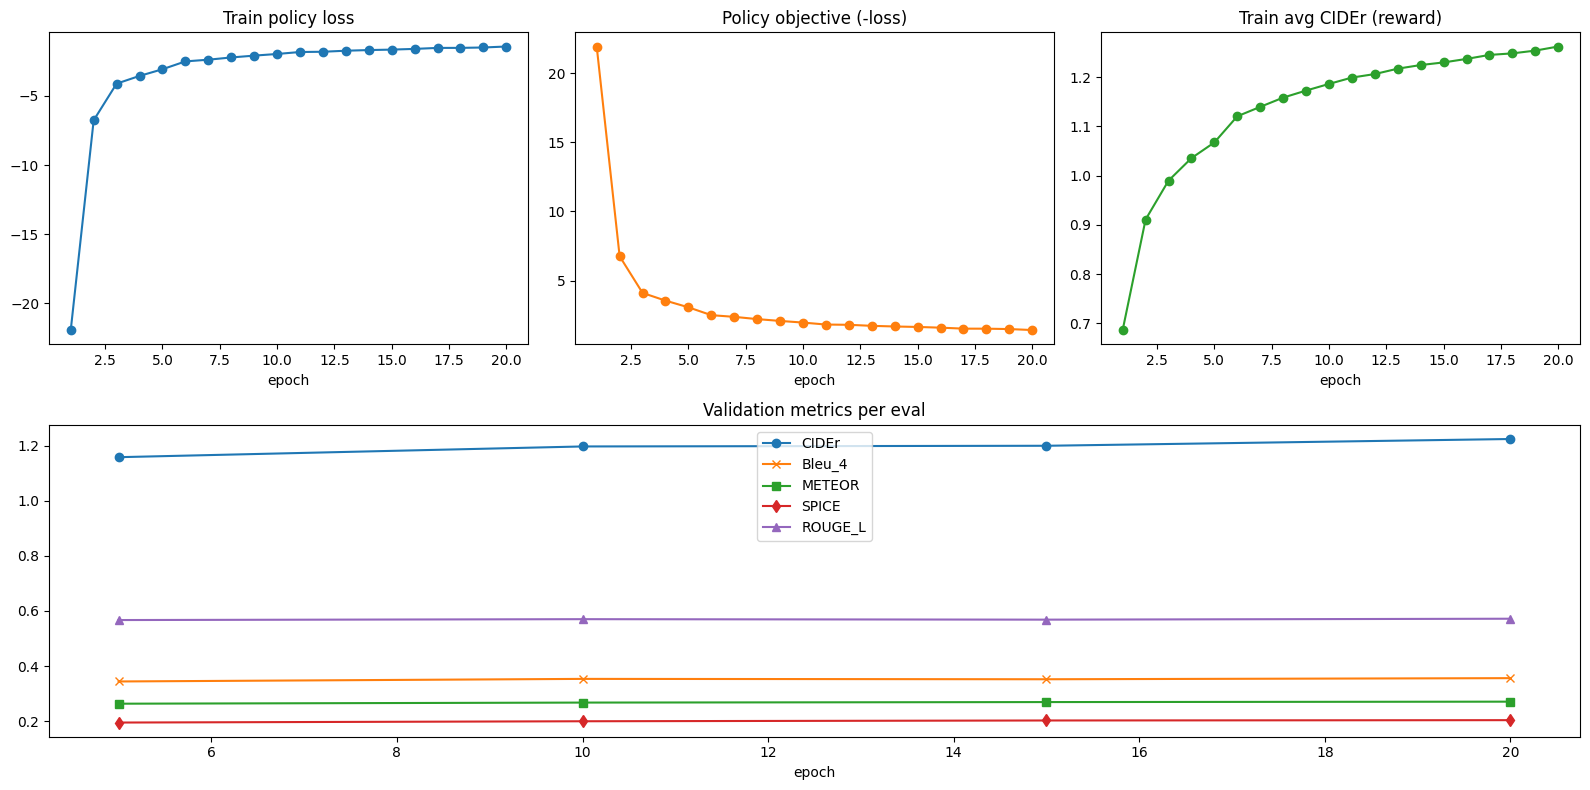

SCST done. Best val CIDEr: 1.2245833963376236


In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.subplot(2,3,1); plt.plot(range(1,len(train_loss_epochs)+1), train_loss_epochs, marker='o'); plt.title('Train policy loss'); plt.xlabel('epoch')
plt.subplot(2,3,2); plt.plot(range(1,len(train_policy_obj_epochs)+1), train_policy_obj_epochs, marker='o', color='C1'); plt.title('Policy objective (-loss)'); plt.xlabel('epoch')
plt.subplot(2,3,3); plt.plot(range(1,len(train_cider_epochs)+1), train_cider_epochs, marker='o', color='C2'); plt.title('Train avg CIDEr (reward)'); plt.xlabel('epoch')
plt.subplot(2,1,2)
if len(val_epochs)>0:
    plt.plot(val_epochs, val_metrics_store["CIDEr"], marker='o', label='CIDEr')
    plt.plot(val_epochs, val_metrics_store["Bleu_4"], marker='x', label='Bleu_4')
    plt.plot(val_epochs, val_metrics_store["METEOR"], marker='s', label='METEOR')
    plt.plot(val_epochs, val_metrics_store["SPICE"], marker='d', label='SPICE')
    plt.plot(val_epochs, val_metrics_store["ROUGE_L"], marker='^', label='ROUGE_L')
    plt.legend(); plt.title('Validation metrics per eval'); plt.xlabel('epoch')
else:
    plt.text(0.5,0.5,'No validation runs', ha='center')
plt.tight_layout(); plt.show()

print("SCST done. Best val CIDEr:", best_val_cider)